In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
tf.debugging.set_log_device_placement(True)

a = tf.constant([[1.0, 2.0]])
b = tf.constant([[3.0], [4.0]])
c = tf.matmul(a, b)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:GPU:0


In [1]:
from google.colab import files
uploaded = files.upload()

Saving delhi_2000_2018.parquet to delhi_2000_2018.parquet


In [2]:
import pandas as pd

df = pd.read_parquet("delhi_2000_2018.parquet")

print(df.shape)


(158566, 15)


step 1

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("GPU:", tf.config.list_physical_devices('GPU'))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
df["event_timestamp"] = pd.to_datetime(df["event_timestamp"])
df = df.sort_values("event_timestamp")
df = df.reset_index(drop=True)


In [5]:
features = [
    "temperature", "humidity", "pressure",
    "wind_speed", "pm25", "pm10",
    "no2", "so2", "o3", "co"
]

target = "aqi"

df_model = df[features + [target]].copy()


In [6]:
train = df_model.iloc[:int(len(df_model)*0.7)]
val   = df_model.iloc[int(len(df_model)*0.7):int(len(df_model)*0.85)]
test  = df_model.iloc[int(len(df_model)*0.85):]

print(train.shape, val.shape, test.shape)


(110996, 11) (23785, 11) (23785, 11)


In [7]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train)
val_scaled   = scaler.transform(val)
test_scaled  = scaler.transform(test)


In [8]:
def create_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])
        y.append(data[i+seq_length, -1])
    return np.array(X), np.array(y)

seq_length = 24

X_train, y_train = create_sequences(train_scaled, seq_length)
X_val, y_val     = create_sequences(val_scaled, seq_length)
X_test, y_test   = create_sequences(test_scaled, seq_length)

print(X_train.shape, y_train.shape)


(110972, 24, 10) (110972,)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
    Dropout(0.2),
    GRU(32),
    Dense(1)
])

gru_model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

gru_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24, 64)         │        14,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,033 (93.88 KB)

 Trainable params: 24,033 (93.88 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=128
)


Epoch 1/20
867/867 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0231 - mae: 0.0692 - val_loss: 0.0026 - val_mae: 0.0386
Epoch 2/20
867/867 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 2.5084e-04 - mae: 0.0112 - val_loss: 0.0022 - val_mae: 0.0334
Epoch 3/20
867/867 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.4196e-04 - mae: 0.0080 - val_loss: 0.0021 - val_mae: 0.0348
Epoch 4/20
867/867 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 1.2493e-04 - mae: 0.0067 - val_loss: 0.0021 - val_mae: 0.0368
Epoch 5/20
867/867 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 1.0911e-04 - mae: 0.0061 - val_loss: 0.0021 - val_mae: 0.0374
Epoch 6/20
867/867 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 9.1894e-05 - mae: 0.0056 - val_loss: 0.0021 - val_mae: 0.0382
Epoch 7/20
867/867 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 8.1047e-05 - mae: 0.0053 - val_loss: 0.0019 - val_mae: 0.0365
Epoch 8/20
867/867 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 6.7691e-05 - mae: 0.0051 - val_loss: 0.0015 - val_mae: 0.0320
Epoch 9/20
867/867 ━━━━━

In [11]:
preds = gru_model.predict(X_test)

mse = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print("GRU Test MSE:", mse)
print("GRU Test MAE:", mae)


743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
GRU Test MSE: 0.019017740167496685
GRU Test MAE: 0.13590991582555775


In [17]:
# Prepare empty array for inverse scaling
temp = np.zeros((len(preds), len(features) + 1))
temp[:, -1] = preds.flatten()

preds_inverse = scaler.inverse_transform(temp)[:, -1]

temp[:, -1] = y_test.flatten()
y_test_inverse = scaler.inverse_transform(temp)[:, -1]

from sklearn.metrics import mean_squared_error, mean_absolute_error

print("GRU Real MSE:", mean_squared_error(y_test_inverse, preds_inverse))
print("GRU Real MAE:", mean_absolute_error(y_test_inverse, preds_inverse))

GRU Real MSE: 822.7835106065768
GRU Real MAE: 28.269262491716027


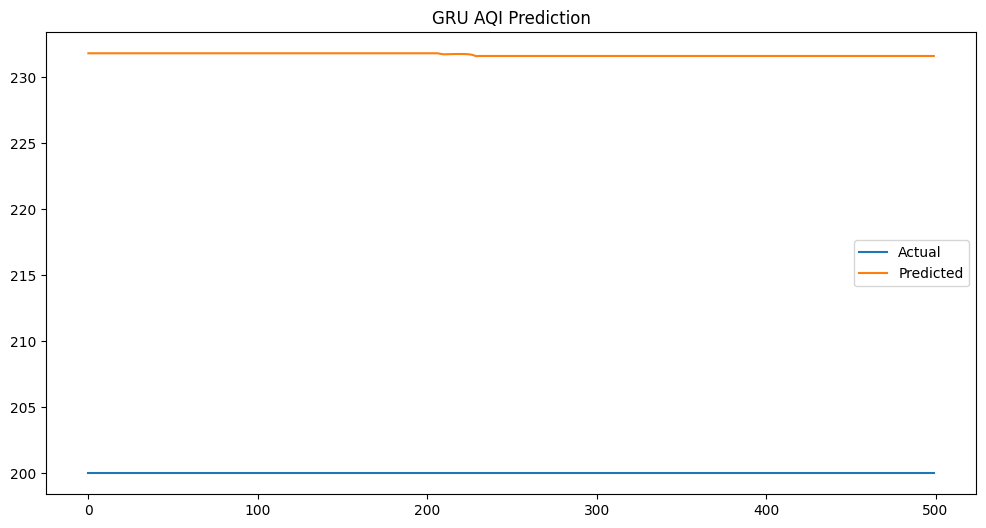

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_inverse[:500], label="Actual")
plt.plot(preds_inverse[:500], label="Predicted")
plt.legend()
plt.title("GRU AQI Prediction")
plt.show()


In [12]:
gru_model.save("gru_model_delhi.keras")


In [13]:
from google.colab import files
files.download("gru_model_delhi.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
from tensorflow.keras.layers import LSTM

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

lstm_model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

lstm_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=128
)

Epoch 1/20
867/867 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0096 - mae: 0.0401 - val_loss: 0.0072 - val_mae: 0.0710
Epoch 2/20
867/867 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 1.5776e-04 - mae: 0.0082 - val_loss: 0.0064 - val_mae: 0.0684
Epoch 3/20
867/867 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 1.0251e-04 - mae: 0.0061 - val_loss: 0.0059 - val_mae: 0.0668
Epoch 4/20
867/867 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 8.0326e-05 - mae: 0.0052 - val_loss: 0.0056 - val_mae: 0.0647
Epoch 5/20
867/867 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 8.6280e-05 - mae: 0.0050 - val_loss: 0.0063 - val_mae: 0.0691
Epoch 6/20
867/867 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 5.8514e-05 - mae: 0.0043 - val_loss: 0.0091 - val_mae: 0.0833
Epoch 7/20
867/867 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 6.6790e-05 - mae: 0.0043 - val_loss: 0.0119 - val_mae: 0.0956
Epoch 8/20
867/867 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 5.7050e-05 - mae: 0.0041 - val_loss: 0.0170 - val_mae: 0.1152
Epoch 9/20
867/867 ━━━━━━━

In [16]:
preds_lstm = lstm_model.predict(X_test)

mse_lstm = mean_squared_error(y_test, preds_lstm)
mae_lstm = mean_absolute_error(y_test, preds_lstm)

print("LSTM Test MSE:", mse_lstm)
print("LSTM Test MAE:", mae_lstm)


743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
LSTM Test MSE: 0.07747964094109885
LSTM Test MAE: 0.2760724217558861


In [19]:
lstm_model.save("lstm_model_delhi.keras")
files.download("lstm_model_delhi.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>